Running all models of Table 3 of the paper

# Data

In [1]:
import data_preparation
import custom_func
from model import Model
from draw_network import DrawNetworkDiagram
    
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from model_mclp import ModelMCLP
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import data
spill_data = pd.read_excel('../data/processed/data_100_oil_spills.xlsx', sheet_name='spills', header=0).copy()
current_station_data = pd.read_excel('../data/raw/data_oil_spill_resource_allocation_Arctic_2023.xlsx', sheet_name='current', header=0).copy()
current_input_param = pd.read_excel('../data/raw/data_oil_spill_resource_allocation_Arctic_2023.xlsx', sheet_name='current input param', header=0).copy()


potential_station_data = pd.read_excel('../data/raw/data_oil_spill_resource_allocation_Arctic_2023.xlsx', sheet_name='stations', header=0).copy()
potential_station_data = potential_station_data.iloc[[0, 4,7, 10, 11, 18]] # if we want to keep current facility setup in the set of proposed facilities
input_parameters = pd.read_excel('../data/raw/data_oil_spill_resource_allocation_Arctic_2023.xlsx', sheet_name='Estimated parameters', header=0).copy()
sensitivity_dataR = gpd.read_file('../data/gis map/ArcGIS_data/Sensitivity_data/Sensitivity_data5.shp').copy()

In [3]:
coordinates_st = custom_func.extract_station_coordinate(current_station_data)
current_st_coord = pd.DataFrame(coordinates_st[1]).T.reset_index().set_index('index')
current_st_coord.columns = ['St_Latitude', 'St_Longitude']
display(current_st_coord)

coordinates_spill = custom_func.extract_spill_coordinate(spill_data)
spill_coord = pd.DataFrame(coordinates_spill[1]).T.reset_index().set_index('index')
spill_coord.columns = ['St_Latitude', 'St_Longitude']
display(spill_coord)

,St_Latitude,St_Longitude
index,,
s6,60.758053,-115.789886
s9,58.550838,-93.623520
s200,69.459000,-132.974304
s300,63.742886,-68.464958


,St_Latitude,St_Longitude
index,,
o74,64.504219,-79.406021
o98,73.858727,-77.062927
o53,58.851135,-94.206932
o178,69.455536,-123.856422
o203,65.388885,-65.952179
...,...,...
o207,61.278797,-114.416603
o43,70.589783,-120.206131
o192,68.705536,-134.233826


## Common input parameters

In [4]:
BigM = 10**20
current_vs_proposed = 'proposed' # current
MaxFO = 1
Budget = 10**12
W = [0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
QuantityMin = 2

# Model C

In [5]:
current_vs_proposed = 'current'
NumberStMax_m3 = 4
DistanceMax = 15

In [6]:
Stations, OilSpills, ResourcesD, Demand, Availability, Eff, Distance, TimeR, Cf_s, CostU \
= data_preparation.generate_input_data(current_station_data, spill_data, current_input_param)

#max(Distance.values())
SizeSpill = SizeSpill_R = list(spill_data['Spill size']).copy()
Sensitivity_R = custom_func.calculate_sensitivity(coordinates_spill[0], sensitivity_dataR)
# normalize
SizeSpill_n = dict(zip(OilSpills, custom_func.normalize(SizeSpill_R, min(SizeSpill_R), max(SizeSpill_R))))
Sensitivity_n = dict(zip(OilSpills, custom_func.normalize(Sensitivity_R, min(Sensitivity_R), max(Sensitivity_R))))

Distance_n = dict(zip(Distance.keys(), custom_func.normalize(Distance.values(), min(Distance.values()), max(Distance.values()))))
# (x_0-x_min)/(x_max-x_min)
Effectiveness_n = dict(zip(Eff.keys(), custom_func.normalize(Eff.values(), min(Eff.values()), max(Eff.values()))))

['s6', 's9', 's200', 's300']


In [7]:
# Modeling based on current setup
model_03, select_m3, deploy_m3, mvars_m3, names_m3, values_m3, objValues_m3, \
        spill_df_m3, station_df_m3, cover_1s_m3, select_1s_m3, deploy_1s_m3, MeanResponseTime_m3, coverage_percentage_m3, assignment_m3  \
    = Model.solve(Stations, OilSpills, ResourcesD, coordinates_st, coordinates_spill, SizeSpill, SizeSpill_n,
          Demand, Sensitivity_R, Sensitivity_n, Eff, Effectiveness_n, Availability, NumberStMax_m3, Distance, Distance_n,
          W, QuantityMin, DistanceMax, Cf_s, CostU, Budget,
          BigM, MaxFO)

--------------MIP-moo--------
Set parameter Username
Academic license - for non-commercial use only - expires 2025-05-03
Set parameter PoolSolutions to value 1024
Set parameter PoolGap to value 0.8
Set parameter LogFile to value "../models/model_moo(May 03,2109).log"
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (mac64[arm] - Darwin 23.2.0 23C71)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 489 rows, 384 columns and 897 nonzeros
Model fingerprint: 0xfb4aa2b4
Variable types: 285 continuous, 99 integer (99 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+23]
  Objective range  [2e-02, 3e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+12]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.

---------------------------------------------------------------------------
Multi-objectives: starting optimization with 2 objectives .

## Fig5a

In [8]:
current_vs_proposed = 'current'

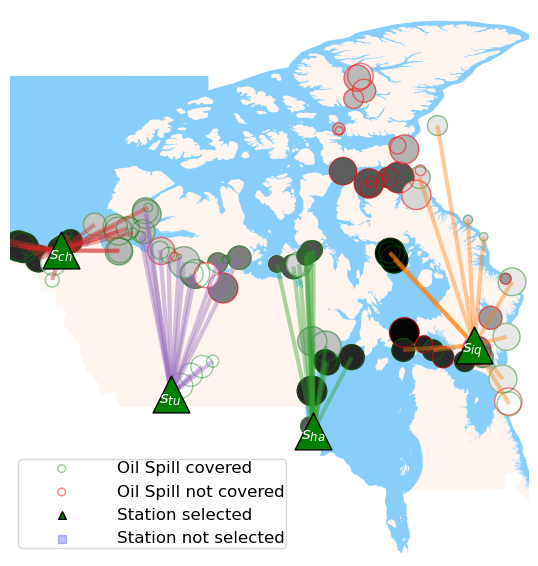

,Spill #,Station no.,St_Latitude,St_Longitude,Spill_Latitude,Spill_Longitude,Resource Type,Quantity deployed,Distance
0,o98,s300,63.742886,-68.464958,73.858727,-77.062927,c,31.0,13.276118
1,o53,s9,58.550838,-93.623520,58.851135,-94.206932,c,110.0,0.656162
3,o178,s200,69.459000,-132.974304,69.455536,-123.856422,c,110.0,9.117882
4,o127,s300,63.742886,-68.464958,69.348618,-81.734749,i,7.0,14.405262
5,o172,s6,60.758053,-115.789886,71.655670,-119.648705,i,7.0,11.560646
...,...,...,...,...,...,...,...,...,...
74,o207,s6,60.758053,-115.789886,61.278797,-114.416603,i,7.0,1.468701
75,o43,s6,60.758053,-115.789886,70.589783,-120.206131,i,157.0,10.778039
77,o192,s200,69.459000,-132.974304,68.705536,-134.233826,i,7.0,1.467686
78,o174,s200,69.459000,-132.974304,72.045486,-119.409912,m,100.0,13.808789


In [9]:
# Fig5a model_c
DrawNetworkDiagram.draw_network_diagram(DistanceMax, NumberStMax_m3, Sensitivity_R, spill_df_m3, station_df_m3, MeanResponseTime_m3, coverage_percentage_m3, assignment_m3, deploy_1s_m3, select_1s_m3, current_vs_proposed)

## Table 3 (model c)

In [10]:
input_output_df_m3 = pd.DataFrame(index=range(1),
                                  columns=['Max no of stations', 'Max distance (kms)','Coverage Percentage', 'Mean Response Time','Objective 1', 'Objective 2'])
input_output_df_m3.iloc[0,0] = NumberStMax_m3
input_output_df_m3.iloc[0,1] = DistanceMax
input_output_df_m3.iloc[0,2] = coverage_percentage_m3
input_output_df_m3.iloc[0,3] = MeanResponseTime_m3
input_output_df_m3.iloc[0,4] = objValues_m3[0::2][1]
input_output_df_m3.iloc[0,5] = objValues_m3[1::2][1]
input_output_df_m3

,Max no of stations,Max distance (kms),Coverage Percentage,Mean Response Time,Objective 1,Objective 2
0,4,15,83,10.93,963.915355,1.25


# Model 2

In [11]:
# Since inputs of models are different (Table 3 first 3 columns), we need to recalculate some params
# Import data
station_data = pd.read_excel('../data/raw/data_oil_spill_resource_allocation_Arctic_2023.xlsx', sheet_name='stations', header=0).copy()


Stations, OilSpills, ResourcesD, Demand, Availability, Eff, Distance, TimeR, Cf_s, CostU \
= data_preparation.generate_input_data(station_data, spill_data, input_parameters)
coordinates_spill = custom_func.extract_spill_coordinate(spill_data)
coordinates_st = custom_func.extract_station_coordinate(station_data)

SizeSpill = SizeSpill_R = list(spill_data['Spill size']).copy()
Sensitivity_R = custom_func.calculate_sensitivity(coordinates_spill[0], sensitivity_dataR)

# normalize  # (x_0-x_min)/(x_max-x_min)
SizeSpill_n = dict(zip(OilSpills, custom_func.normalize(SizeSpill_R, min(SizeSpill_R), max(SizeSpill_R))))
Sensitivity_n = dict(zip(OilSpills, custom_func.normalize(Sensitivity_R, min(Sensitivity_R), max(Sensitivity_R))))
Distance_n = dict(zip(Distance.keys(), custom_func.normalize(Distance.values(), min(Distance.values()), max(Distance.values()))))
Effectiveness_n = dict(zip(Eff.keys(), custom_func.normalize(Eff.values(), min(Eff.values()), max(Eff.values()))))

DistanceMax = 10
current_vs_proposed = 'proposed' # current
MaxFO = 1
W = [0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
QuantityMin = 2

['s1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20']


In [12]:
NumberStMax_m1 = 4

In [13]:
model01, select, deploy, mvars, names, values, objValues, \
        spill_df, station_df, cover_1s, select_1s, deploy_1s, MeanResponseTime, coverage_percentage, assignment  \
    = Model.solve(Stations, OilSpills, ResourcesD, coordinates_st, coordinates_spill, SizeSpill, SizeSpill_n,
          Demand, Sensitivity_R, Sensitivity_n, Eff, Effectiveness_n, Availability, NumberStMax_m1, Distance, Distance_n,
          W, QuantityMin, DistanceMax, Cf_s, CostU, Budget,
          BigM, MaxFO)

--------------MIP-moo--------
Set parameter PoolSolutions to value 1024
Set parameter PoolGap to value 0.8
Set parameter LogFile to value "../models/model_moo(May 03,2109).log"
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (mac64[arm] - Darwin 23.2.0 23C71)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1832 rows, 1436 columns and 4534 nonzeros
Model fingerprint: 0x8ca3fefb
Variable types: 1062 continuous, 374 integer (374 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+25]
  Objective range  [1e-02, 2e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+12]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.

---------------------------------------------------------------------------
Multi-objectives: starting optimization with 2 objectives ... 
---------------------------------------------------------------------------

Mult

## Fig5b: Network Diagram

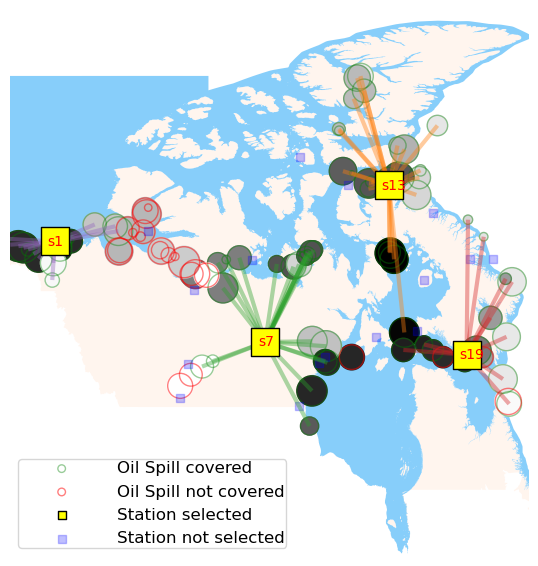

In [14]:
# Draw Network Diagram
assignment_line_m1 = DrawNetworkDiagram.draw_network_diagram(DistanceMax, NumberStMax_m1, Sensitivity_R, spill_df, station_df, MeanResponseTime, coverage_percentage, assignment, deploy_1s, select_1s, current_vs_proposed)
# Fig5b

## Table 3 (model 2)

In [15]:
input_output_df = pd.DataFrame(index=range(1), columns=['Max no of stations', 'Max distance','Coverage Percentage', 'Mean Response Time', 'Objective 1', 'Objective 2'])
input_output_df.iloc[0,0] = NumberStMax_m1
input_output_df.iloc[0,1] = DistanceMax
input_output_df.iloc[0,2] = coverage_percentage
input_output_df.iloc[0,3] = MeanResponseTime
input_output_df.iloc[0,4] = objValues[0::2][1]
input_output_df.iloc[0,5] = objValues[1::2][1]
input_output_df

,Max no of stations,Max distance,Coverage Percentage,Mean Response Time,Objective 1,Objective 2
0,4,10,78,7.94,1006.00302,525.0


## Resource allocation (Table 4)

In [16]:
assignment_line_m1 = pd.DataFrame(columns=list(assignment.columns.values))
for i, o in enumerate(assignment['Spill #'].unique()):
    minD = min(assignment.loc[assignment['Spill #'] == o]['Distance'])
    df = assignment.iloc[np.where(assignment['Distance'] == minD)[0]]
    assignment_line_m1 = pd.concat([assignment_line_m1, df])

resource_allocation_m1 = assignment_line_m1[['Station no.', 'Resource Type', 'Quantity deployed']]
resource_allocation_m1 = resource_allocation_m1.sort_values(by=['Station no.'])
resource_allocation_m1 = resource_allocation_m1.groupby(['Station no.', 'Resource Type'])['Quantity deployed'].mean().reset_index()
resource_allocation_m1['Facility'] = 'Proposed'
resource_allocation_m1

,Station no.,Resource Type,Quantity deployed,Facility
0,s1,c,26.833333,Proposed
1,s1,i,55.750000,Proposed
2,s1,m,60.000000,Proposed
3,s13,c,27.875000,Proposed
4,s13,i,67.000000,Proposed
5,s13,m,48.400000,Proposed
6,s19,c,34.857143,Proposed
7,s19,m,40.666667,Proposed
8,s7,c,61.833333,Proposed
9,s7,i,49.000000,Proposed


# Model 3

In [17]:
NumberStMax_m4a = 5
current_vs_proposed = 'proposed'
DistanceMax_m4a = 10

In [18]:
coordinates_potential_st = custom_func.extract_station_coordinate(potential_station_data)
potential_st_coord = pd.DataFrame(coordinates_potential_st[1]).T.reset_index().set_index('index')
potential_st_coord.columns = ['St_Latitude', 'St_Longitude']
display(potential_st_coord)

,St_Latitude,St_Longitude
index,,
s1,70.000000,-134.000000
s5,60.529999,-114.379997
s8,60.060001,-95.889999
s11,62.669998,-92.708000
s12,73.400002,-88.160004
s19,63.150002,-69.680000


In [19]:
# Input param
Stations, OilSpills, ResourcesD, Demand, Availability, Eff, Distance, TimeR, Cf_s, CostU \
= data_preparation.generate_input_data(potential_station_data, spill_data, input_parameters)

Distance_n = dict(zip(Distance.keys(), custom_func.normalize(Distance.values(), min(Distance.values()), max(Distance.values()))))
# (x_0-x_min)/(x_max-x_min)
Effectiveness_n = dict(zip(Eff.keys(), custom_func.normalize(Eff.values(), min(Eff.values()), max(Eff.values()))))

['s1', 's5', 's8', 's11', 's12', 's19']


## Fig5c

In [20]:
# Model
model_04a, select_m4a, deploy_m4a, mvars_m4a, names_m4a, values_m4a, objValues_m4a, \
        spill_df_m4a, station_df_m4a, cover_1s_m4a, select_1s_m4a, deploy_1s_m4a, MeanResponseTime_m4a, coverage_percentage_m4a, assignment_m4a  \
    = Model.solve(Stations, OilSpills, ResourcesD, coordinates_potential_st, coordinates_spill, SizeSpill, SizeSpill_n,
          Demand, Sensitivity_R, Sensitivity_n, Eff, Effectiveness_n, Availability, NumberStMax_m4a, Distance, Distance_n,
          W, QuantityMin, DistanceMax_m4a, Cf_s, CostU, Budget,
          BigM, MaxFO)

--------------MIP-moo--------
Set parameter PoolSolutions to value 1024
Set parameter PoolGap to value 0.8
Set parameter LogFile to value "../models/model_moo(May 03,2109).log"
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (mac64[arm] - Darwin 23.2.0 23C71)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 545 rows, 426 columns and 1033 nonzeros
Model fingerprint: 0x0c886d39
Variable types: 315 continuous, 111 integer (111 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+25]
  Objective range  [2e-02, 2e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+12]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.

---------------------------------------------------------------------------
Multi-objectives: starting optimization with 2 objectives ... 
---------------------------------------------------------------------------

Multi-o

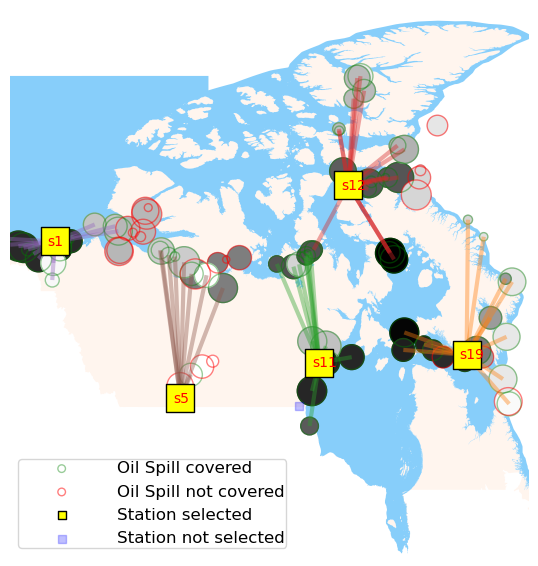

In [21]:
# Draw the network
assignment_line = DrawNetworkDiagram.draw_network_diagram(DistanceMax_m4a, NumberStMax_m4a, Sensitivity_R, spill_df_m4a, station_df_m4a, MeanResponseTime_m4a, coverage_percentage_m4a, assignment_m4a, deploy_1s_m4a, select_1s_m4a, current_vs_proposed)
# Fig5c model3

In [22]:
input_output_df_m4a = pd.DataFrame(index=range(1),
                                  columns=['Max no of stations', 'Max distance (kms)','Coverage Percentage', 'Mean Response Time','Objective 1', 'Objective 2'])
input_output_df_m4a.iloc[0,0] = NumberStMax_m4a
input_output_df_m4a.iloc[0,1] = DistanceMax_m4a
input_output_df_m4a.iloc[0,4] = coverage_percentage_m4a
input_output_df_m4a.iloc[0,5] = MeanResponseTime_m4a
input_output_df_m4a.iloc[0,2] = objValues_m4a[0::2][1]
input_output_df_m4a.iloc[0,3] = objValues_m4a[1::2][1]
input_output_df_m4a

,Max no of stations,Max distance (kms),Coverage Percentage,Mean Response Time,Objective 1,Objective 2
0,5,10,1031.08413,750.0,83,7.7


# Model p (proposed facility config)

In [23]:
potential_station_data = pd.read_excel('../data/raw/data_oil_spill_resource_allocation_Arctic_2023.xlsx', sheet_name='stations', header=0).copy()

In [24]:
DistanceMax_4b = 10
NumberStMax_m4b = 5
current_vs_proposed = 'proposed'

In [25]:
coordinates_potential_st = custom_func.extract_station_coordinate(potential_station_data)
potential_st_coord = pd.DataFrame(coordinates_potential_st[1]).T.reset_index().set_index('index')
potential_st_coord.columns = ['St_Latitude', 'St_Longitude']

In [26]:
# Input param
Stations, OilSpills, ResourcesD, Demand, Availability, Eff, Distance, TimeR, Cf_s, CostU \
= data_preparation.generate_input_data(potential_station_data, spill_data, input_parameters)

Distance_n = dict(zip(Distance.keys(), custom_func.normalize(Distance.values(), min(Distance.values()), max(Distance.values()))))
# (x_0-x_min)/(x_max-x_min)
Effectiveness_n = dict(zip(Eff.keys(), custom_func.normalize(Eff.values(), min(Eff.values()), max(Eff.values()))))

['s1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20']


In [27]:
# Model
model_04b, select_m4b, deploy_m4b, mvars_m4b, names_m4b, values_m4b, objValues_m4b, \
        spill_df_m4b, station_df_m4b, cover_1s_m4b, select_1s_m4b, deploy_1s_m4b, MeanResponseTime_m4b, coverage_percentage_m4b, assignment_m4b  \
    = Model.solve(Stations, OilSpills, ResourcesD, coordinates_potential_st, coordinates_spill, SizeSpill, SizeSpill_n,
          Demand, Sensitivity_R, Sensitivity_n, Eff, Effectiveness_n, Availability, NumberStMax_m4b, Distance, Distance_n,
          W, QuantityMin, DistanceMax_4b, Cf_s, CostU, Budget,
          BigM, MaxFO)

--------------MIP-moo--------
Set parameter PoolSolutions to value 1024
Set parameter PoolGap to value 0.8
Set parameter LogFile to value "../models/model_moo(May 03,2110).log"
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (mac64[arm] - Darwin 23.2.0 23C71)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1832 rows, 1436 columns and 4534 nonzeros
Model fingerprint: 0x8013fd99
Variable types: 1062 continuous, 374 integer (374 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+25]
  Objective range  [1e-02, 2e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+12]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.

---------------------------------------------------------------------------
Multi-objectives: starting optimization with 2 objectives ... 
---------------------------------------------------------------------------

Mult

## Fig5d

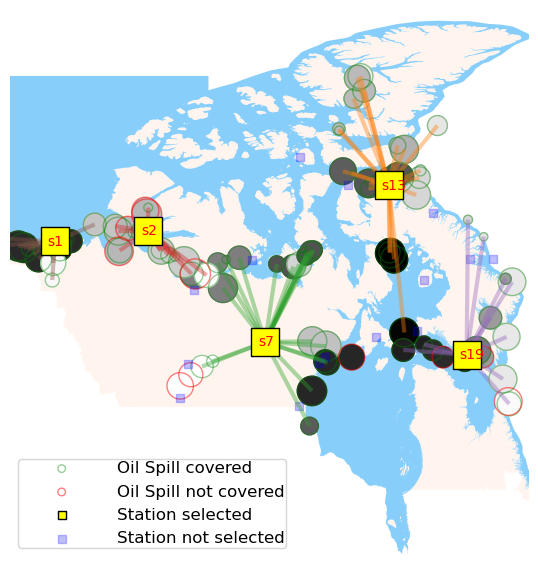

In [28]:
# Draw the network
assignment_line_m4b = DrawNetworkDiagram.draw_network_diagram(DistanceMax_4b, NumberStMax_m4b, Sensitivity_R, spill_df_m4b, station_df_m4b, MeanResponseTime_m4b, coverage_percentage_m4b, assignment_m4b, deploy_1s_m4b, select_1s_m4b, current_vs_proposed)

In [29]:
assignment_m4b

,Spill #,Station no.,St_Latitude,St_Longitude,Spill_Latitude,Spill_Longitude,Resource Type,Quantity deployed,Distance
0,o74,s13,73.400002,-81.830002,64.504219,-79.406021,m,20.0,9.220121
1,o74,s19,63.150002,-69.680000,64.504219,-79.406021,m,20.0,9.819847
2,o98,s13,73.400002,-81.830002,73.858727,-77.062927,c,31.0,4.789095
3,o53,s7,63.930000,-101.139999,58.851135,-94.206932,c,110.0,8.594317
4,o178,s2,70.639999,-119.430000,69.455536,-123.856422,c,110.0,4.582157
...,...,...,...,...,...,...,...,...,...
85,o220,s1,70.000000,-134.000000,69.243050,-137.326294,m,20.0,3.411335
86,o43,s2,70.639999,-119.430000,70.589783,-120.206131,i,157.0,0.777754
87,o192,s1,70.000000,-134.000000,68.705536,-134.233826,c,5.0,1.315413
88,o174,s2,70.639999,-119.430000,72.045486,-119.409912,i,157.0,1.405631


## Table 3 (model p)

In [30]:
input_output_df_m4b = pd.DataFrame(index=range(1), columns=['Max no of stations', 'Max distance (kms)', 'Coverage Percentage', 'Mean Response Time','Objective 1', 'Objective 2'])
input_output_df_m4b.iloc[0,0] = NumberStMax_m4b
input_output_df_m4b.iloc[0,1] = DistanceMax_4b
input_output_df_m4b.iloc[0,2] = coverage_percentage_m4b
input_output_df_m4b.iloc[0,3] = MeanResponseTime_m4b
input_output_df_m4b.iloc[0,4] = objValues_m4b[0::2][1]
input_output_df_m4b.iloc[0,5] = objValues_m4b[1::2][1]
input_output_df_m4b

,Max no of stations,Max distance (kms),Coverage Percentage,Mean Response Time,Objective 1,Objective 2
0,5,10,96,7.63,1127.227354,625.0


# Compare Model c & p

In [31]:
assignment_line_m3 = pd.DataFrame(columns=list(assignment_m3.columns.values))
for i, o in enumerate(assignment_m3['Spill #'].unique()):
    minD = min(assignment_m3.loc[assignment_m3['Spill #'] == o]['Distance'])
    df = assignment_m3.iloc[np.where(assignment_m3['Distance'] == minD)[0]]
    assignment_line_m3 = pd.concat([assignment_line_m3, df])

resource_allocation_m3 = assignment_line_m3[['Station no.', 'Resource Type', 'Quantity deployed']]
resource_allocation_m3 = resource_allocation_m3.sort_values(by=['Station no.'])
resource_allocation_m3 = resource_allocation_m3.groupby(['Station no.', 'Resource Type'])['Quantity deployed'].mean().reset_index()
resource_allocation_m3['Facility'] = 'Current'
resource_allocation_m3

,Station no.,Resource Type,Quantity deployed,Facility
0,s200,c,61.142857,Current
1,s200,i,39.307692,Current
2,s200,m,73.333333,Current
3,s300,c,20.600000,Current
4,s300,i,73.000000,Current
5,s6,c,41.000000,Current
6,s6,i,50.333333,Current
7,s9,c,61.142857,Current
8,s9,i,82.000000,Current
9,s9,m,11.000000,Current


In [32]:
for i, o in enumerate(assignment_m4b['Spill #'].unique()):
    minD = min(assignment_m4b.loc[assignment_m4b['Spill #'] == o]['Distance'])
    df = assignment_m4b.iloc[np.where(assignment_m4b['Distance'] == minD)[0]]
    assignment_line_m4 = pd.concat([assignment_line_m4b, df])

resource_allocation_m4b = assignment_line_m4b[['Station no.', 'Resource Type', 'Quantity deployed']]
resource_allocation_m4b = resource_allocation_m4b.sort_values(by=['Station no.'])
resource_allocation_m4b = resource_allocation_m4b.groupby(['Station no.', 'Resource Type'])['Quantity deployed'].mean().reset_index()
resource_allocation_m4b['Facility'] = 'Proposed'
resource_allocation_m4b

,Station no.,Resource Type,Quantity deployed,Facility
0,s1,c,26.833333,Proposed
1,s1,i,67.000000,Proposed
2,s1,m,60.000000,Proposed
3,s13,c,27.875000,Proposed
4,s13,i,67.000000,Proposed
5,s13,m,48.400000,Proposed
6,s19,c,34.857143,Proposed
7,s19,m,40.666667,Proposed
8,s2,c,83.750000,Proposed
9,s2,i,50.333333,Proposed


In [33]:
resource_allocation = pd.concat([resource_allocation_m3, resource_allocation_m4b])
resource_allocation

,Station no.,Resource Type,Quantity deployed,Facility
0,s200,c,61.142857,Current
1,s200,i,39.307692,Current
2,s200,m,73.333333,Current
3,s300,c,20.600000,Current
4,s300,i,73.000000,Current
5,s6,c,41.000000,Current
6,s6,i,50.333333,Current
7,s9,c,61.142857,Current
8,s9,i,82.000000,Current
9,s9,m,11.000000,Current


<BarContainer object of 23 artists>

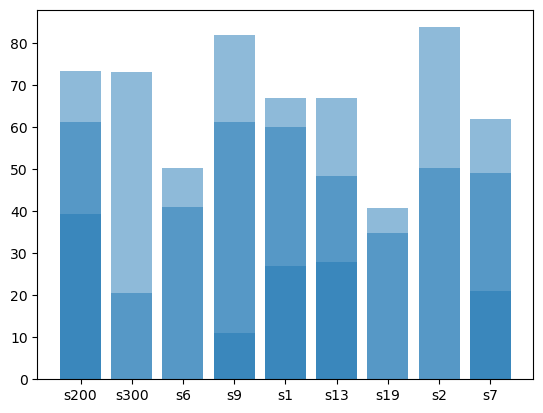

In [34]:
plt.bar(data=resource_allocation,
        x="Station no.", height="Quantity deployed",
        alpha = 0.5,
        )
#plt.legend(loc='upper right')

In [35]:
resource_allocation.to_excel('../data/processed/resource_allocation_model3_vs_model4b.xlsx')

# Model 5

In [36]:
NumberStMax_m5 = 6

In [37]:
potential_station_data = pd.read_excel('../data/raw/data_oil_spill_resource_allocation_Arctic_2023.xlsx', sheet_name='stations', header=0).copy()

In [38]:
current_vs_proposed = 'proposed'

In [39]:
coordinates_potential_st = custom_func.extract_station_coordinate(potential_station_data)
potential_st_coord = pd.DataFrame(coordinates_potential_st[1]).T.reset_index().set_index('index')
potential_st_coord.columns = ['St_Latitude', 'St_Longitude']
# display(potential_st_coord)
# Input param
Stations, OilSpills, ResourcesD, Demand, Availability, Eff, Distance, TimeR, Cf_s, CostU \
= data_preparation.generate_input_data(potential_station_data, spill_data, input_parameters)

Distance_n = dict(zip(Distance.keys(), custom_func.normalize(Distance.values(), min(Distance.values()), max(Distance.values()))))
# (x_0-x_min)/(x_max-x_min)
Effectiveness_n = dict(zip(Eff.keys(), custom_func.normalize(Eff.values(), min(Eff.values()), max(Eff.values()))))

['s1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20']


In [40]:
DistanceMax_m5 = 10

In [41]:
# Model
model_05, select_m5, deploy_m5, mvars_m5, names_m5, values_m5, objValues_m5, \
        spill_df_m5, station_df_m5, cover_1s_m5, select_1s_m5, deploy_1s_m5, MeanResponseTime_m5, coverage_percentage_m5, assignment_m5  \
    = Model.solve(Stations, OilSpills, ResourcesD, coordinates_potential_st, coordinates_spill, SizeSpill, SizeSpill_n,
          Demand, Sensitivity_R, Sensitivity_n, Eff, Effectiveness_n, Availability, NumberStMax_m5, Distance, Distance_n,
          W, QuantityMin, DistanceMax_m5, Cf_s, CostU, Budget,
          BigM, MaxFO)

--------------MIP-moo--------
Set parameter PoolSolutions to value 1024
Set parameter PoolGap to value 0.8
Set parameter LogFile to value "../models/model_moo(May 03,2110).log"
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (mac64[arm] - Darwin 23.2.0 23C71)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1832 rows, 1436 columns and 4534 nonzeros
Model fingerprint: 0xd283bd2c
Variable types: 1062 continuous, 374 integer (374 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+25]
  Objective range  [1e-02, 2e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+12]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.

---------------------------------------------------------------------------
Multi-objectives: starting optimization with 2 objectives ... 
---------------------------------------------------------------------------

Mult

## Fig7a

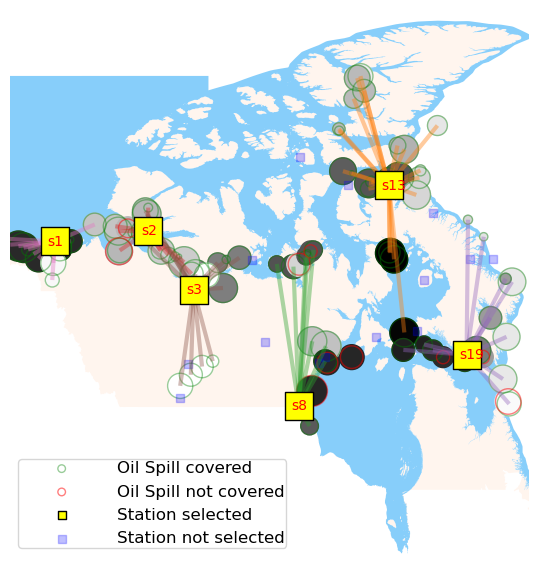

In [42]:
# Fig7a
assignment_line_m5 = DrawNetworkDiagram.draw_network_diagram(DistanceMax_m5, NumberStMax_m5, Sensitivity_R, spill_df_m5, station_df_m5, MeanResponseTime_m5, coverage_percentage_m5, assignment_m5, deploy_1s_m5, select_1s_m5, current_vs_proposed)

## Table 3 (model 5)

In [43]:
input_output_df_m5 = pd.DataFrame(index=range(1), columns=['Max no of stations', 'Max distance', 'Coverage Percentage', 'Mean Response Time','Objective 1', 'Objective 2'])
input_output_df_m5.iloc[0,0] = NumberStMax_m5
input_output_df_m5.iloc[0,1] = DistanceMax_m5
input_output_df_m5.iloc[0,2] = coverage_percentage_m5
input_output_df_m5.iloc[0,3] = MeanResponseTime_m5
input_output_df_m5.iloc[0,4] = objValues_m5[0::2][1]
input_output_df_m5.iloc[0,5] = objValues_m5[1::2][1]
input_output_df_m5

,Max no of stations,Max distance,Coverage Percentage,Mean Response Time,Objective 1,Objective 2
0,6,10,99,7.01,1149.128698,-3943.930278


# Model 6

In [44]:
NumberStMax_m2 = 8

In [45]:
model02, select_m2, deploy_m2, mvars_m2, names_m2, values_m2, objValues_m2, \
        spill_df_m2, station_df_m2, cover_1s_m2, select_1s_m2, deploy_1s_m2, MeanResponseTime_m2, coverage_percentage_m2, assignment_m2  \
    = Model.solve(Stations, OilSpills, ResourcesD, coordinates_st, coordinates_spill, SizeSpill, SizeSpill_n,
          Demand, Sensitivity_R, Sensitivity_n, Eff, Effectiveness_n, Availability, NumberStMax_m2, Distance, Distance_n,
          W, QuantityMin, DistanceMax, Cf_s, CostU, Budget,
          BigM, MaxFO)

--------------MIP-moo--------
Set parameter PoolSolutions to value 1024
Set parameter PoolGap to value 0.8
Set parameter LogFile to value "../models/model_moo(May 03,2110).log"
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (mac64[arm] - Darwin 23.2.0 23C71)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1832 rows, 1436 columns and 4534 nonzeros
Model fingerprint: 0xe1c5bc19
Variable types: 1062 continuous, 374 integer (374 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+25]
  Objective range  [1e-02, 2e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+12]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.

---------------------------------------------------------------------------
Multi-objectives: starting optimization with 2 objectives ... 
---------------------------------------------------------------------------

Mult

## Table 3 (model 6)

In [46]:
input_output_df_m2 = pd.DataFrame(index=range(1), columns=['Max no of stations', 'Max distance (kms)', 'Coverage Percentage', 'Mean Response Time','Objective 1', 'Objective 2'])
input_output_df_m2.iloc[0,0] = NumberStMax_m2
input_output_df_m2.iloc[0,1] = DistanceMax
input_output_df_m2.iloc[0,4] = coverage_percentage_m2
input_output_df_m2.iloc[0,5] = MeanResponseTime_m2
input_output_df_m2.iloc[0,2] = objValues_m2[0::2][1]
input_output_df_m2.iloc[0,3] = objValues_m2[1::2][1]
input_output_df_m2

,Max no of stations,Max distance (kms),Coverage Percentage,Mean Response Time,Objective 1,Objective 2
0,8,10,1149.278387,-5592.989139,99,7.39


# Compare with traditional MCLP model

In [47]:
DistanceMax_mclp = 8
NumberStMax_mclp = 5
current_vs_proposed = 'proposed'

coordinates_potential_st = custom_func.extract_station_coordinate(potential_station_data)
potential_st_coord = pd.DataFrame(coordinates_potential_st[1]).T.reset_index().set_index('index')
potential_st_coord.columns = ['St_Latitude', 'St_Longitude']

# Input param
Stations, OilSpills, ResourcesD, Demand, Availability, Eff, Distance, TimeR, Cf_s, CostU \
= data_preparation.generate_input_data(potential_station_data, spill_data, input_parameters)

Distance_n = dict(zip(Distance.keys(), custom_func.normalize(Distance.values(), min(Distance.values()), max(Distance.values()))))
# (x_0-x_min)/(x_max-x_min)
Effectiveness_n = dict(zip(Eff.keys(), custom_func.normalize(Eff.values(), min(Eff.values()), max(Eff.values()))))

['s1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20']


In [48]:
#max(Distance.values())
SizeSpill = SizeSpill_R = list(spill_data['Spill size']).copy()
Sensitivity_R = custom_func.calculate_sensitivity(coordinates_spill[0], sensitivity_dataR)
# normalize
SizeSpill_n = dict(zip(OilSpills, custom_func.normalize(SizeSpill_R, min(SizeSpill_R), max(SizeSpill_R))))
Sensitivity_n = dict(zip(OilSpills, custom_func.normalize(Sensitivity_R, min(Sensitivity_R), max(Sensitivity_R))))


In [49]:
# Model
model_04b, select_m4b, deploy_m4b, mvars_m4b, names_m4b, values_m4b, objValues_m4b, \
        spill_df_m4b, station_df_m4b, cover_1s_m4b, select_1s_m4b, deploy_1s_m4b, MeanResponseTime_m4b, coverage_percentage_m4b, assignment_m4b  \
    = ModelMCLP.solve(Stations, OilSpills, ResourcesD, coordinates_potential_st, coordinates_spill, SizeSpill, SizeSpill_n,
          Demand, Sensitivity_R, Sensitivity_n, Eff, Effectiveness_n, Availability, NumberStMax_mclp, Distance, Distance_n,
          W, QuantityMin, DistanceMax_mclp, Cf_s, CostU, Budget,
          BigM, MaxFO)

len of OilSpills:  100
--------------MIP-moo--------
Set parameter PoolSolutions to value 1024
Set parameter PoolGap to value 0.8
Set parameter LogFile to value "../models/model_moo(May 03,2110).log"
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (mac64[arm] - Darwin 23.2.0 23C71)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 501 rows, 1020 columns and 1322 nonzeros
Model fingerprint: 0xc598b417
Variable types: 750 continuous, 270 integer (270 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e-04, 2e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+00]
Found heuristic solution: objective -0.0000000
Presolve removed 212 rows and 780 columns
Presolve time: 0.00s
Presolved: 289 rows, 240 columns, 680 nonzeros
Variable types: 0 continuous, 240 integer (240 binary)
Found heuristic solution: objective 8.6297050

Root relaxation: objective 9.787894e+00, 201 iter

In [50]:
print(MeanResponseTime_m4b, coverage_percentage_m4b)

5.41 79
